C:\Users\wara_\AppData\Local\Temp\ipykernel_32816\3255127903.py:21: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s')
C:\Users\wara_\AppData\Local\Temp\ipykernel_32816\3255127903.py:43: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Market_returns = yf.download(Market, start=start_date, end=end_date, interval='1d')['Close']
[*********************100%***********************]  57 of 57 completed
C:\Users\wara_\AppData\Local\Temp\ipykernel_32816\3255127903.py:51: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values pr

Regression results for Market in Fear:
                            OLS Regression Results                            
Dep. Variable:     Absolute_Deviation   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                     243.0
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           5.81e-28
Time:                        17:09:07   Log-Likelihood:                 97.277
No. Observations:                  46   AIC:                            -184.6
Df Residuals:                      41   BIC:                            -175.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

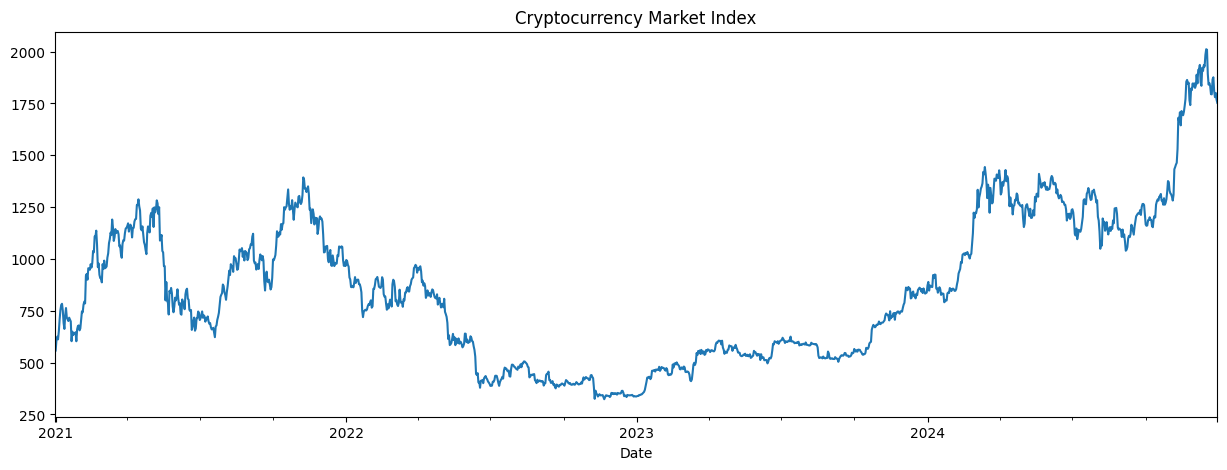

In [14]:
#FINISHED REGRESSION ANALYSIS


import requests
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm

# Define the date range
start_date = '2020-12-31'
end_date = '2024-12-31'

# Get Fear and Greed Index
def get_fear_greed_index():
    url = "https://api.alternative.me/fng/?limit=0"  # Fetch all available data
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        fear_greed_df = pd.DataFrame(data['data'])
        fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s')
        fear_greed_df = fear_greed_df[(fear_greed_df['timestamp'] >= start_date) & (fear_greed_df['timestamp'] <= end_date)]
        F_G = fear_greed_df[['timestamp', 'value']].copy()
        F_G.index = F_G['timestamp']
        F_G = F_G.drop(columns='timestamp')
        return F_G
    else:
        print(f"Error: Request failed with status code {response.status_code}")
        return None

F_G = get_fear_greed_index()

# Define the market assets
Market = ['BTC-USD', 'ETH-USD', 'XRP-USD', 'BNB-USD', 'SOL-USD', 'DOGE-USD', 'ADA-USD', 'LINK-USD', 'SHIB-USD',
          'HBAR-USD', 'DOT-USD', 'XLM-USD', 'BCH-USD', 'LEO-USD', 'UNI7083-USD', 'LTC-USD', 'NEAR-USD', 'AAVE-USD',
          'KCS-USD', 'MKR-USD', 'SAND-USD', 'GALA-USD', 'CRV-USD', 'CRO-USD', 'ETC-USD', 'VET-USD', 'XMR-USD',
          'RENDER-USD', 'OM-USD', 'FET-USD', 'FIL-USD', 'OKB-USD', 'ALGO-USD', 'ATOM-USD', 'STX4847-USD',
          'THETA-USD', 'FTM-USD', 'INJ-USD', 'GRT6719-USD', 'LDO-USD', 'RUNE-USD', 'GT-USD', 'FLR-USD', 'QNT-USD',
          'XTZ-USD', 'BEAM-USD', 'FTT-USD', 'EOS-USD', 'HNT-USD', 'JUP-USD', 'XDC-USD', 'AR-USD', 'IOTA-USD',
          'BTTOLD-USD', 'BSV-USD', 'AXS-USD', 'ZEC-USD']

# Get Market Data
Market_returns = yf.download(Market, start=start_date, end=end_date, interval='1d')['Close']

#plot the market returns index
returns_index = Market_returns.sum(axis = 1) / len(Market) #equally weighted market portfolio to calculate market returns

returns_index.plot(figsize = (15,5), title = 'Cryptocurrency Market Index') #plots the market price movements over four years from 01/01/2021 - 01/01/2025 of the equally weighted market portfolio.

# Calculate daily returns
Market_returns = Market_returns.pct_change()
# Calculate daily volume changes
Market_volume = yf.download(Market, start=start_date, end=end_date, interval='1d')['Volume'].pct_change()

# Filter for Fear and Greed conditions
fear_market = F_G[F_G['value'].astype(int) <= 35].index
nuetral_market = F_G[(F_G['value'].astype(int) > 35) & (F_G['value'].astype(int) < 60)].index
greed_market = F_G[F_G['value'].astype(int) >= 65].index

fear_data = Market_returns.loc[fear_market].dropna()
greed_data = Market_returns.loc[greed_market].dropna()
nuetral_data = Market_returns.loc[nuetral_market].dropna()

# Calculate Market Variables for Fear and Greed
def compute_market_variables(data, volume):
    equally_weighted_market_return = data.mean(axis=1)
    absolute_market_return = np.abs(equally_weighted_market_return)
    equally_weighted_market_squared_return = equally_weighted_market_return ** 2
    market_volume = volume.mean(axis=1)
    deviation = data.sub(equally_weighted_market_return, axis=0)
    average_absolute_deviation = deviation.abs().mean(axis=1)
    return pd.DataFrame({
        'Absolute_Deviation': average_absolute_deviation,
        'Market_Return': equally_weighted_market_return,
        'Abs_Market_Return': absolute_market_return,
        'Market_Squared_Return': equally_weighted_market_squared_return,
        'Market_Volume': market_volume
    }).dropna()



fear_regression_data = compute_market_variables(fear_data, Market_volume.loc[fear_market])
greed_regression_data = compute_market_variables(greed_data, Market_volume.loc[greed_market])
nuetral_regression_data = compute_market_variables(nuetral_data, Market_volume.loc[nuetral_market])
# Run OLS Regression for Fear and Greed
for label, dataset in zip(['Market in Fear', 'Market in Greed','Market in Nuetral'], [fear_regression_data, greed_regression_data, nuetral_regression_data]):
    y = dataset['Absolute_Deviation']
    X = dataset[['Market_Return', 'Abs_Market_Return', 'Market_Squared_Return', 'Market_Volume']]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"Regression results for {label}:")
    print(model.summary())

In [12]:
compute_market_variables(Market_returns, Market_volume)

,Absolute_Deviation,Market_Return,Abs_Market_Return,Market_Squared_Return,Market_Volume
Date,,,,,
2021-01-01,0.106707,0.051698,0.051698,0.002673,inf
2021-01-02,0.073853,0.016173,0.016173,0.000262,0.426548
2021-01-03,0.070542,0.059525,0.059525,0.003543,0.278601
2021-01-04,0.054478,0.025229,0.025229,0.000636,0.722184
2021-01-05,0.046824,0.049443,0.049443,0.002445,0.278221
...,...,...,...,...,...
2024-12-26,0.037154,-0.068381,0.068381,0.004676,0.273995
2024-12-27,0.053089,0.014813,0.014813,0.000219,0.081880
2024-12-28,0.038606,0.018523,0.018523,0.000343,-0.210664
